<h1>Содержание<span class="tocSkip"></span></h1>
<span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [2]:
!pip install --upgrade scikit-learn -q

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
#import phik
import math
import re
#import shap
#import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from statsmodels.tsa.seasonal import seasonal_decompose
#from phik import resources, report
#from phik.report import plot_correlation_matrix
from scipy import stats as st
from scipy.stats import randint, mode
from math import sqrt
from math import factorial
from matplotlib import pyplot as plt
from scipy.stats import binom, norm
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,  DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
#from category_encoders import BinaryEncoder
from sklearn.metrics import (
    confusion_matrix, 
    precision_score, 
    recall_score, 
    accuracy_score, 
    r2_score, 
    mean_squared_error, 
    mean_absolute_error,
    roc_auc_score,
    make_scorer,
    f1_score
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from pmdarima import auto_arima
#from statsmodels.tsa.arima.model import ARIMA
#from imblearn.over_sampling import SMOTE
import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
stopwords = list(set(nltk_stopwords.words('english')))
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.feature_extraction.text import TfidfVectorizer
from pymystem3 import Mystem


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [9]:
data_tc = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [10]:
def inf(df, r):
    df1=df.head(r)
    df2=df.info()
    return display(df1, df2)

In [11]:
inf(data_tc, 10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


None

In [12]:
data_tc = data_tc.reset_index(drop=True)

In [13]:
data_tc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


**Данные загружены, соответствуют описанию, типы данных в порядке, пропусков в данных нет.**

In [14]:
data_tc.index.duplicated().sum()

0

**Дубликаты отсутствуют. Переходим к анализу.**

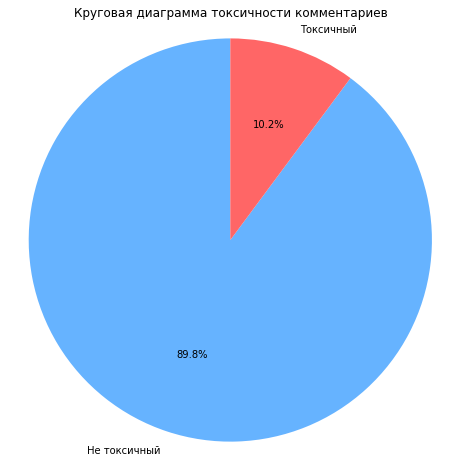

In [15]:
plt.figure(figsize=(8, 8))
plt.pie(data_tc['toxic'].value_counts(), labels=['Не токсичный', 'Токсичный'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff6666'])
plt.title('Круговая диаграмма токсичности комментариев')
plt.axis('equal')  
plt.show()

**Видим, что доля токсичных комментариев около 10%.**

In [16]:
def clean_tc(row):
    row = re.sub(r"(?:\n|\r)", " ", row)
    row = re.sub(r"[^a-zA-Z ]+", "", row).strip()
    row = row.lower()
    return row

data_tc['text'] = data_tc['text'].apply(clean_tc)

corpus = data_tc['text'].values

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    lemmas = []
    for token, pos in pos_tags:
        wordnet_pos = get_wordnet_pos(pos) or wordnet.NOUN
        lemma = lemmatizer.lemmatize(token, pos=wordnet_pos)
        lemmas.append(lemma)
    return ' '.join(lemmas)

#def lemmatize(text):
#    words = text.split()
#    lemm_text = " ".join([lemmatizer.lemmatize(word) for word in words])
#    return lemm_text

#data_tc['lemm_text'] = corpus.apply(clean_tc) 
data_tc['lemm_text'] = [lemmatize(text) for text in corpus]

In [17]:
data_tc.head()

,text,toxic,lemm_text
0,explanation why the edits made under my userna...,0,explanation why the edits make under my userna...
1,daww he matches this background colour im seem...,0,daww he match this background colour im seemin...
2,hey man im really not trying to edit war its j...,0,hey man im really not try to edit war it just ...
3,more i cant make any real suggestions on impro...,0,more i cant make any real suggestion on improv...
4,you sir are my hero any chance you remember wh...,0,you sir be my hero any chance you remember wha...


**Подготовка завершена, перейдём к обучению модели.**

## Обучение

In [18]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
X_train, X_test, y_train, y_test = train_test_split(
        data_tc['lemm_text'], 
        data_tc['toxic'],
        test_size = TEST_SIZE, 
        random_state=RANDOM_STATE,
        stratify = data_tc['toxic']
    )

In [19]:
count_tf_idf_train = TfidfVectorizer(stop_words=stopwords)
tf_idf_train = count_tf_idf_train.fit_transform(X_train)

In [20]:
tf_idf_train.shape

(119469, 173545)

In [21]:
count_tf_idf_test = TfidfVectorizer(stop_words=stopwords)
tf_idf_test = count_tf_idf_train.transform(X_test)

In [22]:
tf_idf_test.shape

(39823, 173545)

In [23]:
f1_scorer = make_scorer(f1_score)

pipe_final = Pipeline([
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 10000, 1000)  
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5)  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=f1_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=50
)
randomized_search.fit(tf_idf_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict(tf_idf_test) 
#y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика F1 на тестовой выборке: {f1_score(y_test, y_test_pred)}')
print(f'Параметры лучшей модели: {randomized_search.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START models=DecisionTreeClassifier(random_state=42), models__max_depth=3, models__max_features=5002
[CV 1/5; 1/10] END models=DecisionTreeClassifier(random_state=42), models__max_depth=3, models__max_features=5002;, score=0.343 total time=   1.4s
[CV 2/5; 1/10] START models=DecisionTreeClassifier(random_state=42), models__max_depth=3, models__max_features=5002
[CV 2/5; 1/10] END models=DecisionTreeClassifier(random_state=42), models__max_depth=3, models__max_features=5002;, score=0.166 total time=   1.4s
[CV 3/5; 1/10] START models=DecisionTreeClassifier(random_state=42), models__max_depth=3, models__max_features=5002
[CV 3/5; 1/10] END models=DecisionTreeClassifier(random_state=42), models__max_depth=3, models__max_features=5002;, score=0.344 total time=   1.4s
[CV 4/5; 1/10] START models=DecisionTreeClassifier(random_state=42), models__max_depth=3, models__max_features=5002
[CV 4/5; 1/10] END models=Decision

**Обучена модель, которая удовлетворяет требованиям задания, метрика F1 на тестовой выборке 0.775, что превышает 0.75. Это модель LogisticRegression с параметрами:**
- C=3, 
- penalty='l1', 
- solver='liblinear'

## Выводы

**В ходе выполнения данной работы была проведена подготовка данных и обучена модель, которая будет находить токсичные комментарии и отправлять их на модерацию. Были обучены модели дерева решений и логистической регрессии, с различными гиперпараметрами, в результате была найдена лучшая модель - модель LogisticRegression со следующими параметрами:**

- C=3,
- penalty='l1',
- solver='liblinear'.

**Метрика F1 данной модели 0.776, что удовлетворяет требованиям заказчика.**

**Рекомендовано применение данной модели для поиска токсичных комментариев пользователей интернет-магазина «Викишоп».**

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны